# Disaggregated population estimates: Residential surface approach
This notebook demonstrates a residential surface approach for disaggregated population estimates, as shown in:
* [Une méthode pour l’estimation désagrégée de données de population à l’aide de données ouvertes](https://hal.inria.fr/hal-01667975)

### Requirements
* INSEE population count data, please refer to the notebook [6-Disaggregated-population-estimates-Pre-requisites](https://github.com/lgervasoni/urbansprawl/tree/master/examples/6-Disaggregated-population-estimates-Pre-requisites.ipynb)

### Approach
* End-to-end framework for computing disaggregated population mapping at building-level.
* Using urban data extracted from the OpenStreetMap database, the surface for residential use associated to each building is retrieved.
* A constant residential surface consumption per-capita is assumed for the downscaling procedure.
* Carried out for French cities, where fine-grained population count data exist, hence enabling a validation procedure.

In [1]:
# snippet for relative imports
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path: sys.path.append(module_path)

import matplotlib.pyplot as plt
import osmnx as ox
import urbansprawl as us

ox.config(log_file=True, log_console=True, log_name='disaggregated_population_residential', log_filename='disaggregated_population_residential', use_cache=True)
figsize = (12,8)

### Retrieve city's OpenStreetMap data
* Lyon, France

In [2]:
city_ref = "Lyon"
east, north, south, west = 4.988479, 45.8421941, 45.6606074, 4.725495
region_args = {"east":east, "north":north, "south":south, "west":west}

%time df_osm_buildings, df_osm_building_parts, df_osm_pois = us.get_processed_osm_data(city_ref=city_ref, region_args=region_args)
%time osm_street_network = us.get_route_graph(city_ref)

CPU times: user 1h 52min 50s, sys: 14.7 s, total: 1h 53min 5s
Wall time: 1h 53min 33s
CPU times: user 8.87 s, sys: 8.02 ms, total: 8.88 s
Wall time: 8.94 s


(633629.300666893, 655288.400079834, 5057445.22201418, 5078670.954256057)

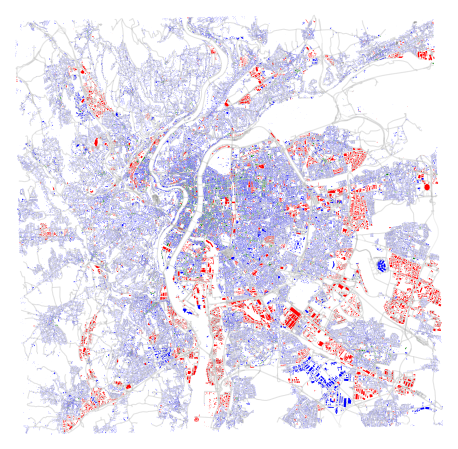

In [3]:
# Get buildings per classification
df_residential = df_osm_buildings[ df_osm_buildings.classification.isin(["residential"]) ]
df_activities = df_osm_buildings[ df_osm_buildings.classification.isin(["activity"]) ]
df_mixed = df_osm_buildings[ df_osm_buildings.classification.isin(["mixed"]) ]

# Plot
f, ax = ox.plot_graph(osm_street_network, fig_height=figsize[1], fig_width=figsize[0], edge_alpha=0.15, node_alpha=0, show=False, close=False)
# Buildings
if (not df_residential.empty):
    df_residential.plot(figsize=figsize, color="blue", ax=ax)
if (not df_activities.empty):
    df_activities.plot(figsize=figsize, color="red", ax=ax)
if (not df_mixed.empty):
    df_mixed.plot(figsize=figsize, color="green", ax=ax)
ax.axis('off')

### Population count data
* Resolution: 200m x 200m
* INSEE population count data, please refer to the pre-requisites notebook [6-Disaggregated-population-estimates-Pre-requisites](https://github.com/lgervasoni/urbansprawl/tree/master/examples/6-Disaggregated-population-estimates-Pre-requisites.ipynb)

In [4]:
# Set the path to the INSEE population count data shapefiles
file_insee_shapefile = "./population_data/insee/carr_pop4326.shp"
file_insee_population_count = "./population_data/insee/car_m.dbf"
                                                                                                                                                                                                            
assert os.path.isfile(file_insee_shapefile), "Verify pre-requisites: https://github.com/lgervasoni/urbansprawl/tree/master/examples/6-Disaggregated-population-estimates-Pre-requisites.ipynb"
assert os.path.isfile(file_insee_population_count),  "Verify pre-requisites: https://github.com/lgervasoni/urbansprawl/tree/master/examples/6-Disaggregated-population-estimates-Pre-requisites.ipynb"

CPU times: user 3min 39s, sys: 2.48 s, total: 3min 42s
Wall time: 3min 42s


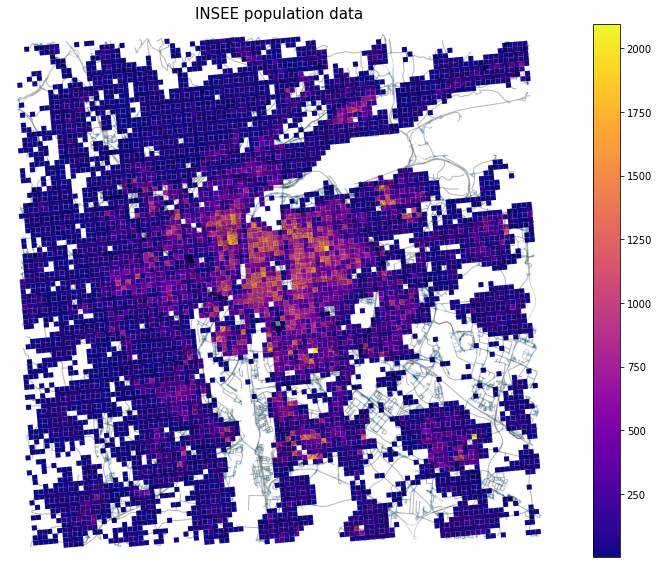

In [5]:
# Extract population count data for region of interest
%time df_pop_insee = us.get_extract_population_data(city_ref=city_ref, data_source="insee", to_crs=df_osm_buildings.crs, pop_shapefile=file_insee_shapefile, pop_data_file=file_insee_population_count, polygons_gdf=df_osm_buildings)

# Plot INSEE
fig, ax = ox.plot_graph(osm_street_network, fig_height=figsize[1], fig_width=figsize[0], close=False, show=False, edge_color='black', edge_alpha=0.15, node_alpha=0.05)
df_pop_insee.plot("pop_count", ax=ax, cmap='plasma', legend=True)
ax.set_title("INSEE population data", fontsize=15)
fig.tight_layout()

### Aggregate gridded population data
* Simulate a resolution of 1km² (1km x 1km)
    * 1 aggregated cell is equivalent in surface to 25 INSEE grid-cells
* At this resolution, world-wide population count data exists (Gridded Population of the World)

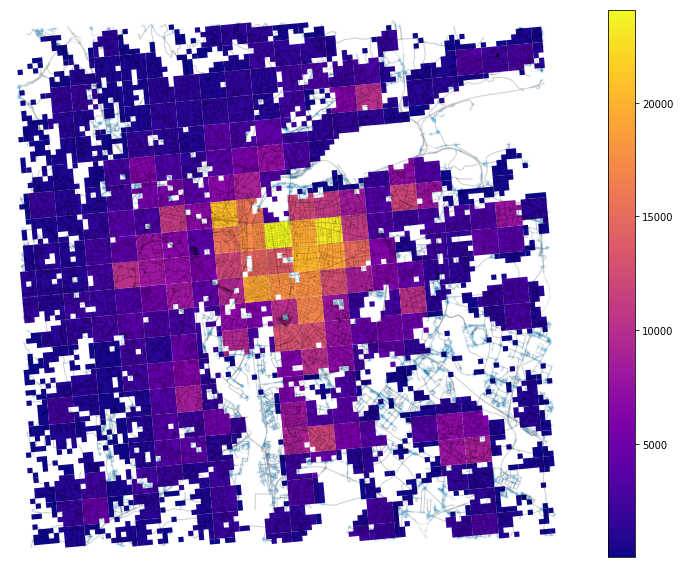

In [6]:
# Get aggregated population data (at GPW's resolution)
df_insee_square_group = us.get_aggregated_squares(df_pop_insee)
# Plot
fig, ax = ox.plot_graph(osm_street_network, fig_height=figsize[1], fig_width=figsize[0], close=False, show=False, edge_color='black', edge_alpha=0.1, node_alpha=0.1)
df_insee_square_group.plot("pop_count", ax=ax, cmap='plasma', legend=True)
fig.tight_layout()

### Disaggregated population estimates
* Population downscaling proportional to the residential surface computed for each grid-cell

In [7]:
# Downscaling using aggregated squares
%time us.proportional_population_downscaling(df_osm_buildings, df_insee_square_group)

CPU times: user 4min 35s, sys: 1.06 s, total: 4min 36s
Wall time: 4min 36s


In [8]:
# Verify population downscaled within each square
%time us.population_downscaling_validation(df_osm_buildings, df_pop_insee)

CPU times: user 1min 50s, sys: 4.02 ms, total: 1min 50s
Wall time: 1min 50s


## Results
* Population data comparison
    * Projected to latitude-longitude coordinates
    * Left: INSEE data (Ground-truth)
    * Right: Disaggregated population estimates

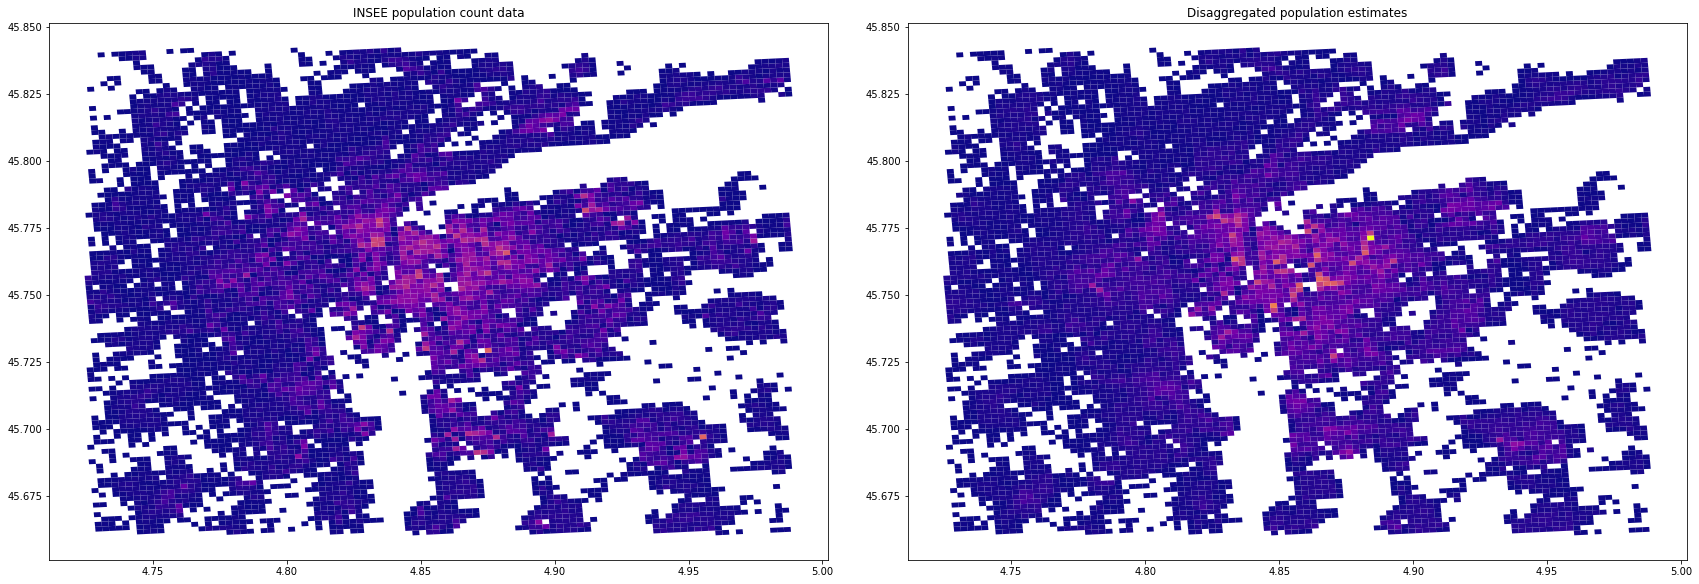

In [9]:
# Plot
fig, axs = plt.subplots(1,2, figsize=(figsize[0] * 2, figsize[1]))
# Title
axs[0].set_title("INSEE population count data"); axs[1].set_title("Disaggregated population estimates")
vmax = max( df_pop_insee.pop_estimation.max(), df_pop_insee.pop_count.max() )
# Plots
ox.project_gdf(df_pop_insee, to_latlong=True).plot("pop_count", figsize=figsize, cmap='plasma', ax=axs[0], vmin=0, vmax=vmax)
ox.project_gdf(df_pop_insee, to_latlong=True).plot("pop_estimation", figsize=figsize, cmap='plasma', ax=axs[1], vmin=0, vmax=vmax)
fig.tight_layout()

* Visualize data frame
    * pop_count: Contains the population ground-truth for each gridded square
    * pop_estimation: Denotes the estimated population count from the downscaling procedure
    * absolute_error: Absolute error between the ground-truth population count and the estimated population count
    * relative_error: Relative error of the population estimation procedure

In [10]:
df_pop_insee.loc[ len(df_pop_insee.index)/2 : len(df_pop_insee.index)/2 + 10 ]

,geometry,idINSPIRE,pop_count,pop_estimation,absolute_error,relative_error
3292,"POLYGON ((645952.4358469523 5068603.313767838,...",CRS3035RES200mN2529600E3922200,512.0,773.970461,261.970461,0.511661
3293,"POLYGON ((646151.3896935658 5068621.761740349,...",CRS3035RES200mN2529600E3922400,764.5,575.833187,188.666813,0.246785
3294,"POLYGON ((646350.3436109978 5068640.199630152,...",CRS3035RES200mN2529600E3922600,276.5,716.535866,440.035866,1.591450
3295,"POLYGON ((646549.3076855931 5068658.637346633,...",CRS3035RES200mN2529600E3922800,848.0,521.054111,326.945889,0.385549
3296,"POLYGON ((646748.2620104273 5068677.08506442, ...",CRS3035RES200mN2529600E3923000,823.0,857.102179,34.102179,0.041436
3297,"POLYGON ((646947.2164066245 5068695.522699623,...",CRS3035RES200mN2529600E3923200,600.5,618.042973,17.542973,0.029214
3298,"POLYGON ((647146.1709627784 5068713.960250054,...",CRS3035RES200mN2529600E3923400,250.5,370.406994,119.906994,0.478671
3299,"POLYGON ((647345.1356768712 5068732.397627333,...",CRS3035RES200mN2529600E3923600,9.0,0.000000,9.000000,1.000000
3300,"POLYGON ((647743.0456790939 5068769.282302574,...",CRS3035RES200mN2529600E3924000,19.5,204.504159,185.004159,9.487393
3301,"POLYGON ((647941.9900831465 5068787.629622484,...",CRS3035RES200mN2529600E3924200,43.0,212.773235,169.773235,3.948215


* Relative error

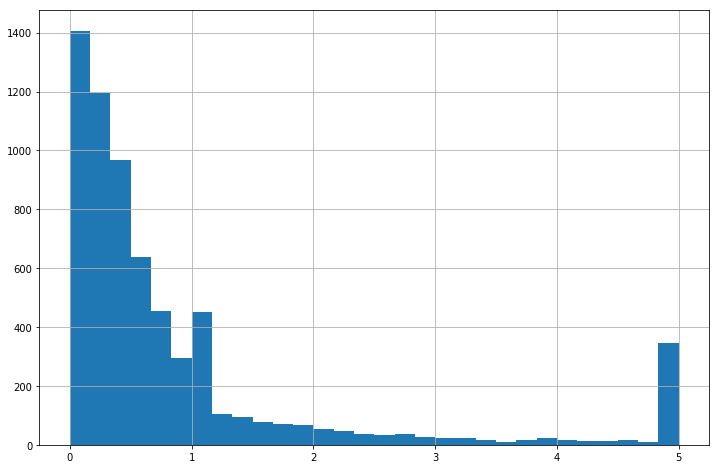

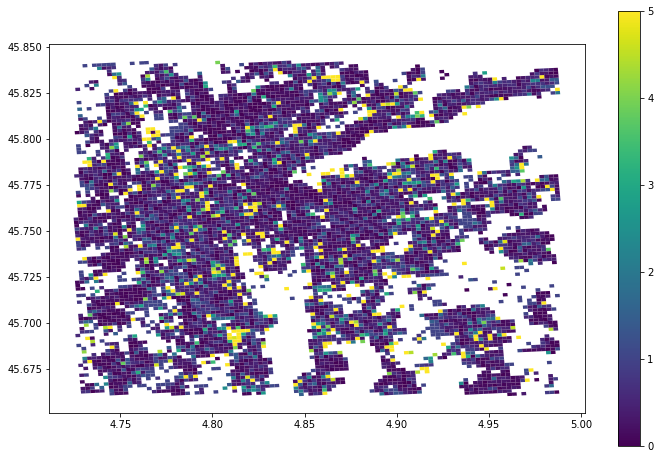

In [11]:
# Bins for error plots
num_bins = 30
# Truncate max relative error for visualization purpose
max_rel_err = 5.
df_pop_insee.loc[ df_pop_insee.relative_error > max_rel_err , "relative_error"] = max_rel_err
# Relative error histogram
df_pop_insee.relative_error.hist(bins=num_bins, figsize=figsize, grid=True)
# Relative error plot
ox.project_gdf(df_pop_insee, to_latlong=True).plot("relative_error", figsize=figsize, legend=True)

* Absolute error

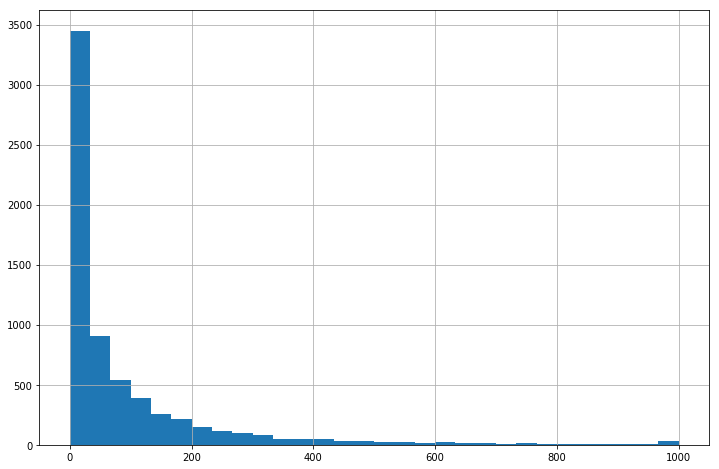

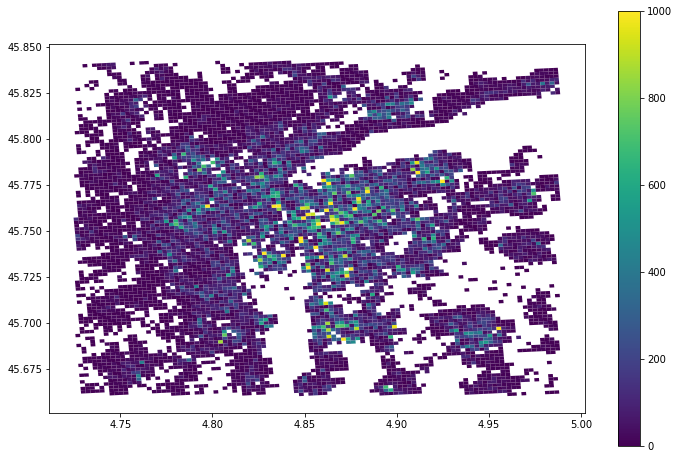

In [12]:
# Truncate max absolute error for visualization purpose
max_abs_err = 1000
df_pop_insee.loc[ df_pop_insee.absolute_error > max_abs_err , "absolute_error"] = max_abs_err
# Absolute error histogram
num_bins = 30
df_pop_insee.absolute_error.hist(bins=num_bins, figsize=figsize, grid=True)
# Absolute error plot
ox.project_gdf(df_pop_insee, to_latlong=True).plot("absolute_error", figsize=figsize, legend=True)